In [51]:
# Set directory to main directory (only run this once)
import os
dir_path = os.getcwd()
os.chdir('/'.join(dir_path.split('/')[:-1]))

In [52]:
# Import things
import numpy as np
import torch
import torch
import torch.func as func
import matplotlib.pyplot as plt
from PIL import Image
from src.domain import Domain
from src.utils import *
from src.transformations import Affine2d
from src.interpolation import SplineInter 
from src.plotting import view_image_2d
from src.interpolation import SplineInter
from src.distance import SSDDistance
from src.LinearOperator import LinearOperator

torch.set_default_dtype(torch.float64)

# Estimating Dynamics from an Unregistered Time Series

In [53]:
# Load data
root_directory = 'data/dynamics/d_affine/'

domain = Domain.load(root_directory + 'domain')
time = torch.load(root_directory + 'time.pt').double().detach()
d_2d = torch.load(root_directory + 'd.pt').double().detach()
f_2d = torch.load(root_directory + 'f_true.pt').double().detach()
masks_2d = torch.load(root_directory + 'masks.pt').double().detach()
alpha_true = torch.load(root_directory + 'alpha_true.pt').double().detach()


mx,my = domain.m
n_images = len(time)
n_masks = masks_2d.shape[0]

hx,hy = domain.h
ht = time[1] - time[0]

FileNotFoundError: [Errno 2] No such file or directory: 'data/dynamics/d_affine/domain'

In [ ]:
fig, ax = plt.subplots(1,5, figsize=(10,2.6))

for j in range(5):
    im = view_image_2d(d_2d[5*j], domain, ax=ax[j], kwargs={'clim':(0,300), 'cmap':'Greys_r'})
    ax[j].set_title("{:.2f}s".format(time[5*j].item()),fontsize=16)
    ax[j].set_xticklabels([])
    ax[j].set_yticklabels([])

fig.suptitle('Dynamic Contrast Enhanced MRI Imaging', y = .95, fontsize=18)

fig.subplots_adjust(0.01,-.1,.99,1)

plt.savefig('results/dynamics/contrast_demonstration.pdf')
plt.show()

In [ ]:
plt.rcParams['text.usetex'] = True

fig, ax = plt.subplots(1,2,figsize = (12,4), width_ratios=[1,1], layout='tight')

im = view_image_2d(d_2d[0],domain, ax = ax[0], kwargs={'clim':(0,300), 'cmap':'Greys_r'})
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])

view_image_2d(masks_2d[0],domain,{'alpha':.4*masks_2d[0].T,'cmap':'seismic'}, ax=ax[0])
view_image_2d(masks_2d[1],domain,{'alpha':.4*masks_2d[1].T}, ax=ax[0])

ax[0].scatter([],[],color='darkred',label="Medulla")
ax[0].scatter([],[],color='y',label="Cortex")
ax[0].legend()

ax[0].set_title("Kidney Segmentation", y=1.05, fontsize = 18)

cbar = plt.colorbar(im,shrink=.98)
cbar.set_label(label = "Intensity", fontsize = 14)

ax[1].plot(time, alpha_true[:,0], color='darkred', label=r"$\alpha_m$ (Medulla Dynamics)")
ax[1].plot(time, alpha_true[:,1], color='y', label=r"$\alpha_c$ (Cortex Dynamics)")
ax[1].legend(fontsize=14)

ax[1].set_xlabel('Time [s]', fontsize=14)
ax[1].set_ylabel('Intensity', fontsize=14)

ax[1].set_title("True Dynamics", y=1.05, fontsize = 18)

fig.suptitle("Dynamic Estimation Problem Setup", y=.95, fontsize=24)

plt.savefig('results/dynamics/problem_setup.pdf', bbox_inches='tight')

plt.show()

In [ ]:
d = d_2d.reshape(n_images, mx*my)
f = f_2d.reshape(n_images, mx*my)
masks = masks_2d.reshape(n_masks, mx*my)

# Solving For Dynamics with Unregistered Images

In [111]:
D = torch.diff(torch.eye(n_images), dim=0)
Tau = torch.diag(1. * (time[:-1] > 10) + .1 * (time[:-1] < 10))

# Find best lambda

In [ ]:
def true_error(L_alpha):
    A = torch.vstack([torch.kron(torch.eye(n_images), masks.T.contiguous()) * (hx * hy)**.5, L_alpha * torch.kron(Tau @ D, torch.eye(n_masks)) / ht**.5])
    alpha_unregistered = torch.linalg.lstsq(A, 
                                            torch.hstack([(d - d[0]).flatten() * (hx * hy)**.5, torch.zeros(D.shape[0]*n_masks)])
                                            )[0].reshape(n_images,n_masks)
    return torch.linalg.norm(alpha_unregistered - alpha_true)

Ls = torch.logspace(-10,10,100)
error = [true_error(L) for L in Ls]

plt.loglog(Ls,error)

In [ ]:
L_alpha = Ls[torch.argmin(torch.Tensor(error))]

A = torch.vstack([torch.kron(torch.eye(n_images), masks.T.contiguous()) * (hx * hy)**.5, L_alpha * torch.kron(Tau @ D, torch.eye(n_masks)) / ht**.5])

In [ ]:
L_alpha

In [ ]:
alpha_unregistered = torch.linalg.lstsq(A, 
                                        torch.hstack([(d - d[0]).flatten() * (hx * hy)**.5, torch.zeros(D.shape[0]*n_masks)])
                                        )[0].reshape(n_images,n_masks)

plt.figure(figsize=(10,5))

plt.plot(time, alpha_true[:,0], '--', color='darkred', label=r"True $\alpha_m$")
plt.plot(time, alpha_true[:,1], '--', color='y', label=r"True $\alpha_c$")

plt.plot(time, alpha_unregistered[:,0], color='darkred', label=r"$\alpha_m$ Unregistered Estimate")
plt.plot(time, alpha_unregistered[:,1], color='y', label=r"$\alpha_c$ Unregistered Estimate")

plt.legend(fontsize=14)

plt.xlabel('Time [s]', fontsize=18)
plt.ylabel('Intensity', fontsize=18)

plt.title("Estimated Dynamics from Unregistered Images",fontsize=24, y=1.03)


plt.savefig('results/dynamics/unregistered_alpha.pdf', bbox_inches='tight')

plt.show()

# Solving For Dynamics with Preregistered Images

In [ ]:
# out = [func.jacfwd(Forward_single, has_aux=True)(wp_vec.reshape(-1,6)[j], ys[j], d_interp[j+1]) for j in range(n_images - 1)]
out[0][1].shape

In [62]:
xc_2d = domain.getCellCenteredGrid()
xc = xc_2d.reshape(mx*my,2).detach()

ys = [Affine2d() for _ in range(n_images-1)]

thetas = torch.logspace(5,-3, 10)

wps = [{k: v.detach() for k, v in y.named_parameters()} for y in ys]
keys_list = [wp.keys() for wp in wps]

flat_params_list, shapes_list, sizes_list = flatten_params_list(wps)
wp_vec = torch.stack(flat_params_list).flatten().unsqueeze(1)

# Start Registration
print(100*'-')
print("Registering Multiple Images :")
print(100*'-')

f_pred = d.clone().detach()

for theta in thetas:
    print("Registering at Scale {} with Gauss Newton".format(theta))

    d_interp = [SplineInter(d[j].reshape(mx,my).clone().detach(), domain, regularizer='moments', theta=theta) for j in range(n_images)]

    d0_stack = torch.vstack([d_interp[0](xc) for _ in range(n_images - 1)]).detach()

    def Forward_single(wp, y, d_inter):
        w_dict = unflatten_params(wp, keys_list[0], shapes_list[0], sizes_list[0])
        yc = func.functional_call(y, w_dict, xc)
        f_pred = d_inter(yc)
        return f_pred, f_pred
        
    def loss_fn(wp_vec, ys, d_interp):
        F = torch.vstack([Forward_single(wp_vec.reshape(-1,6)[j], ys[j], d_interp[j+1])[0] for j in range(n_images - 1)])
        return torch.linalg.norm(F - d0_stack)**2 * torch.prod(domain.h)

    iter = 0

    loss = []
    loss.append(loss_fn(wp_vec, ys, d_interp))
    gradnorm = []
    gradnorm.append(torch.inf)

    while gradnorm[-1] > 1e3 and iter < 50:
        print("iter \t {} \t | \t loss \t {} \t | \t gradnorm \t {}".format(iter,loss[-1],gradnorm[-1]))
        out = [func.jacfwd(Forward_single, has_aux=True)(wp_vec.reshape(-1,6)[j], ys[j], d_interp[j+1]) for j in range(n_images - 1)]
        Jacs = [o[0].squeeze() for o in out]
        Jac = torch.block_diag(*Jacs)
        F = torch.vstack([o[1] for o in out])
        
        res = F - d0_stack
        gradnorm.append(torch.linalg.norm(Jac.T @ res))
        p = torch.vstack([torch.linalg.lstsq(Jacs[j], -res.reshape(n_images-1,-1)[j,:])[0] for j in range(n_images - 1)]).reshape(-1,1)
        
        step_size = 1
        for _ in range(10):
            if loss_fn(wp_vec + step_size * p, ys, d_interp) < loss[iter]:
                wp_vec += step_size * p
                break
            step_size *= .5
        loss.append(loss_fn(wp_vec, ys, d_interp))

        iter += 1

        f_pred[1:] = F.reshape(n_images - 1, mx*my)

wp_vec_prereg = wp_vec.clone()
f_pred_prereg = f_pred.clone()

----------------------------------------------------------------------------------------------------
Registering Multiple Images :
----------------------------------------------------------------------------------------------------
Registering at Scale 100000.0 with Gauss Newton
iter 	 0 	 | 	 loss 	 51621001.780272916 	 | 	 gradnorm 	 inf
iter 	 1 	 | 	 loss 	 40726855.11583378 	 | 	 gradnorm 	 67209846.79456359
iter 	 2 	 | 	 loss 	 40470694.78501198 	 | 	 gradnorm 	 10425042.830912126
iter 	 3 	 | 	 loss 	 40462580.668710776 	 | 	 gradnorm 	 1981638.489289603
iter 	 4 	 | 	 loss 	 40462255.80011892 	 | 	 gradnorm 	 428697.8470524325
iter 	 5 	 | 	 loss 	 40462242.42848025 	 | 	 gradnorm 	 100966.78484364653
iter 	 6 	 | 	 loss 	 40462241.678240746 	 | 	 gradnorm 	 25066.630070454048
iter 	 7 	 | 	 loss 	 40462241.38737646 	 | 	 gradnorm 	 6440.146299408797
iter 	 8 	 | 	 loss 	 40462241.38304384 	 | 	 gradnorm 	 1697.4706065050284
Registering at Scale 12915.496650148827 with Gauss N

In [63]:
theta = 0

d_interp = [SplineInter(d[j].reshape(mx,my).detach(), domain, regularizer='moments', theta=0) for j in range(n_images)]

def Forward(wp_vec, xc):
        w_dict = unflatten_params_list(wp_vec.reshape(n_images-1,6), keys_list, shapes_list, sizes_list)
        ycs = [func.functional_call(y, wp, xc) for wp, y in zip(w_dict, ys)]
        f_preds = torch.vstack([d_interp[j+1](ycs[j]) for j in range(n_images - 1)])
        return f_preds, f_preds

f_pred[1:] = Forward(wp_vec, xc)[0].reshape(n_images - 1, mx*my)

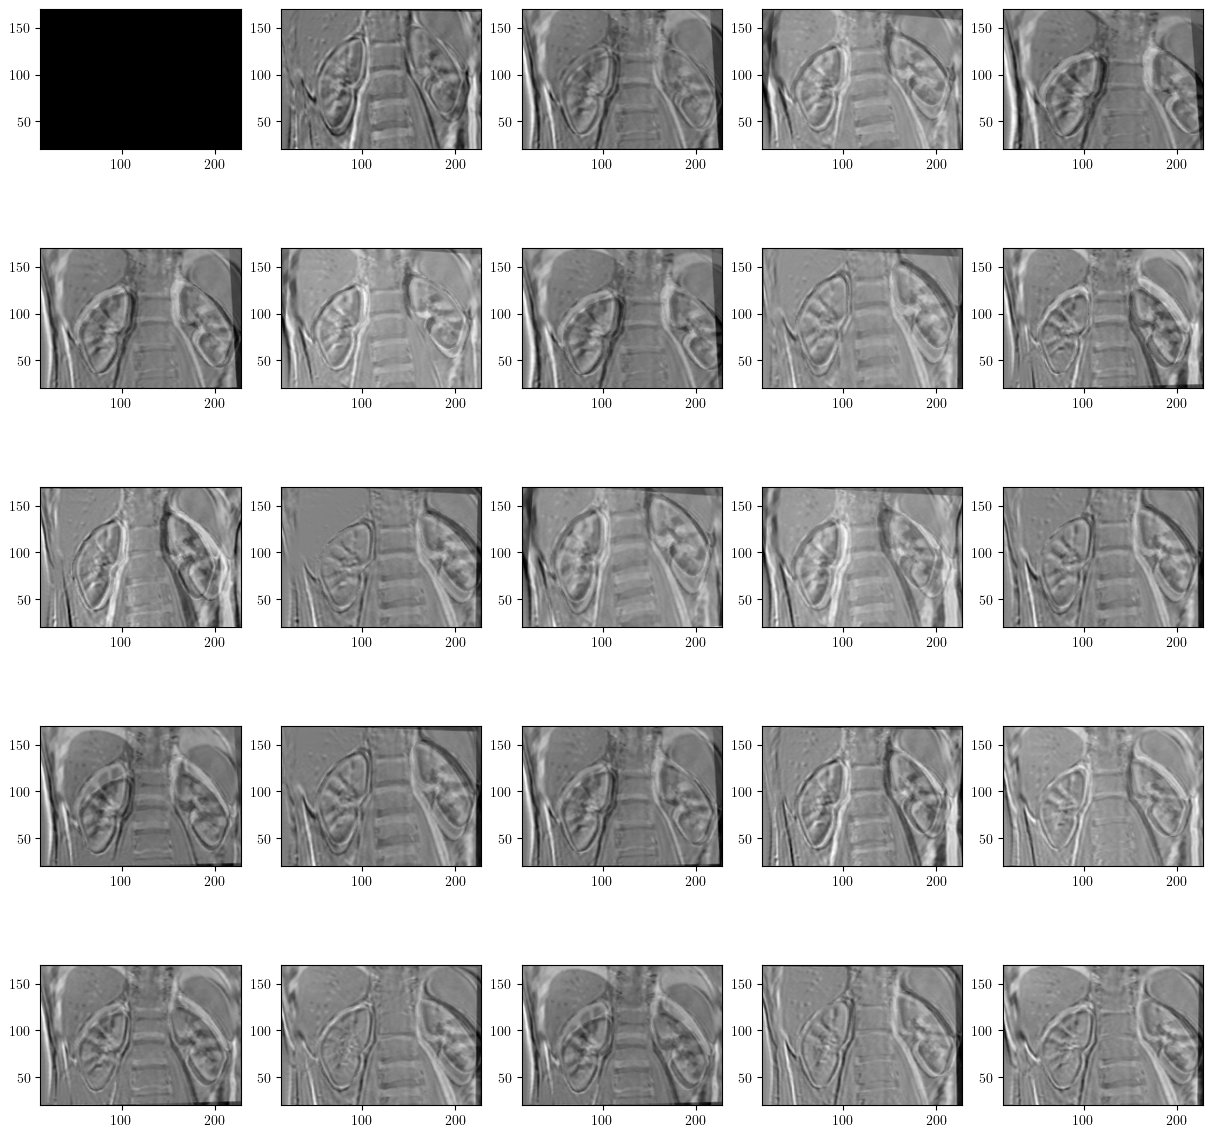

In [64]:
fig, ax = plt.subplots(5,5,figsize=(15,15))

for j in range(0,n_images):
    view_image_2d(f_pred[j].reshape(mx,my).detach() - d_2d[j], domain, ax=ax[j//5,j%5])

In [65]:
alpha_true.shape

torch.Size([25, 2])

In [66]:
torch.diff(torch.eye(n_images-1), dim=0).shape

torch.Size([23, 24])

In [74]:
MM = torch.kron(torch.eye(n_images-1), M) * (hx * hy)**.5
DD = L_alpha * torch.kron(torch.diff(torch.eye(n_images-1), dim=0), torch.eye(n_masks)) / ht**.5
DD.shape

torch.Size([46, 48])

In [95]:
xc_2d = domain.getCellCenteredGrid()
xc = xc_2d.reshape(mx*my,2).detach()

ys = [Affine2d() for _ in range(n_images-1)]

thetas = torch.logspace(-2,-3, 2)

wps = [{k: v.detach() for k, v in y.named_parameters()} for y in ys]
keys_list = [wp.keys() for wp in wps]

flat_params_list, shapes_list, sizes_list = flatten_params_list(wps)
wp_vec = torch.stack(flat_params_list).flatten().unsqueeze(1)

# Start Registration
print(100*'-')
print("Registering Multiple Images :")
print(100*'-')

f_pred = d.clone().detach()

for theta in thetas:
    print("Registering at Scale {} with Gauss Newton".format(theta))
    Mimgs = [
            SplineInter(mask.reshape(mx,my), domain, regularizer='moments', theta=theta) for mask in masks
            ]
    M = (torch.stack([Mimg(xc).detach() for Mimg in Mimgs], dim=-1).squeeze())
    A = torch.vstack([torch.kron(torch.eye(n_images-1), M) * (hx * hy)**.5, L_alpha * torch.kron(torch.diff(torch.eye(n_images-1), dim=0), torch.eye(n_masks)) / ht**.5])
    
    Q,R = torch.linalg.qr(A, mode='reduced')
    d_interp = [SplineInter(d[j].reshape(mx,my).clone().detach(), domain, regularizer='moments', theta=theta) for j in range(n_images)]

    d0_stack = torch.vstack([d_interp[0](xc) for _ in range(n_images - 1)]).detach()
    Q = Q[:d0_stack.shape[0],:]
    def Forward_single(wp, y, d_inter):
        w_dict = unflatten_params(wp, keys_list[0], shapes_list[0], sizes_list[0])
        yc = func.functional_call(y, w_dict, xc)
        f_pred = d_inter(yc)
        return f_pred, f_pred
        
    def loss_fn(wp_vec, ys, d_interp):
        F = torch.vstack([Forward_single(wp_vec.reshape(-1,6)[j], ys[j], d_interp[j+1])[0] for j in range(n_images - 1)])
        res = F - d0_stack
        resp = res - Q @ (Q.T @ res)
        return torch.linalg.norm(resp)**2 * torch.prod(domain.h)

    iter = 0

    loss = []
    loss.append(loss_fn(wp_vec, ys, d_interp))
    gradnorm = []
    gradnorm.append(torch.inf)

    while gradnorm[-1] > 1e3 and iter < 50:
        print("iter \t {} \t | \t loss \t {} \t | \t gradnorm \t {}".format(iter,loss[-1],gradnorm[-1]))

        out = [func.jacfwd(Forward_single, has_aux=True)(wp_vec.reshape(-1,6)[j], ys[j], d_interp[j+1]) for j in range(n_images - 1)]
        Jacs = [o[0].squeeze() for o in out]
        Jac = torch.block_diag(*Jacs)
        F = torch.vstack([o[1] for o in out])
        
        res = F - d0_stack
        resp = (res - Q @ (Q.T @ res))
        gradnorm.append(torch.linalg.norm(Jac.T @ resp))

        U,S,Vt = torch.linalg.svd(Jac, full_matrices=False)
        # count number of singular values larger than 1e-3
        r = torch.sum(S > 1e-3*S[0])
        # remove small singular values
        S = S[:r]
        U = U[:,:r]
        Vt = Vt[:r,:]
        # solve the least squares problem
        p = Vt.T @ torch.linalg.solve(torch.diag(S), - (U.T @ resp))

        # p = torch.linalg.lstsq(Jac, -resp)[0]

        step_size = 1
        for _ in range(10):
            if loss_fn(wp_vec + step_size * p, ys, d_interp) < loss[iter]:
                wp_vec += step_size * p
                break
            step_size *= .5
        loss.append(loss_fn(wp_vec, ys,d_interp))

        iter += 1

        f_pred[1:] = F.reshape(n_images - 1, mx*my)

wp_vec_coupled = wp_vec.clone()
f_pred_coupled = f_pred.clone()



----------------------------------------------------------------------------------------------------
Registering Multiple Images :
----------------------------------------------------------------------------------------------------
Registering at Scale 0.01 with Gauss Newton
iter 	 0 	 | 	 loss 	 731556420.7552086 	 | 	 gradnorm 	 inf
iter 	 1 	 | 	 loss 	 659577132.2776611 	 | 	 gradnorm 	 1025264216.0951755
iter 	 2 	 | 	 loss 	 615121995.4528056 	 | 	 gradnorm 	 890832313.5291005
iter 	 3 	 | 	 loss 	 582964368.8258837 	 | 	 gradnorm 	 793826814.4904
iter 	 4 	 | 	 loss 	 557144193.9898927 	 | 	 gradnorm 	 716960660.8533744
iter 	 5 	 | 	 loss 	 534331170.46419674 	 | 	 gradnorm 	 693222552.082849
iter 	 6 	 | 	 loss 	 514868410.98437566 	 | 	 gradnorm 	 645335639.7508616
iter 	 7 	 | 	 loss 	 497728996.6446916 	 | 	 gradnorm 	 624628348.720646
iter 	 8 	 | 	 loss 	 481552660.7575197 	 | 	 gradnorm 	 633214168.9524043
iter 	 9 	 | 	 loss 	 466282379.66512346 	 | 	 gradnorm 	 6335492

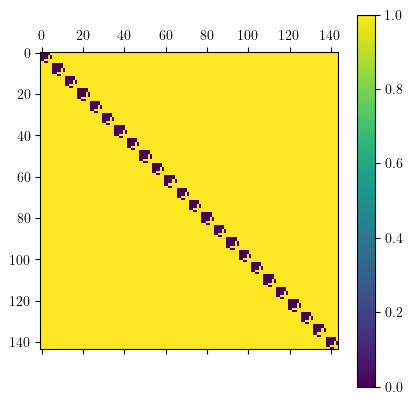

In [102]:
plt.matshow(Jac.T@Jac < 1e8)
plt.colorbar()

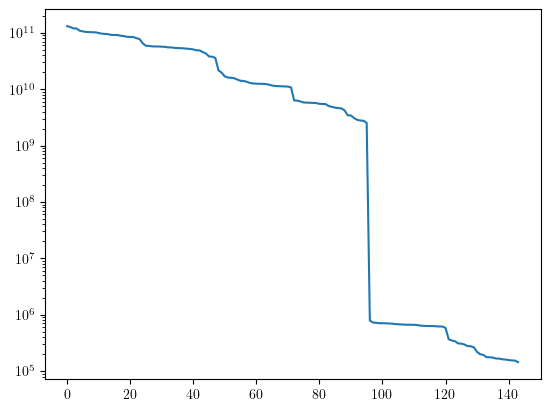

In [103]:
plt.semilogy(torch.svd(Jac.T@Jac).S)

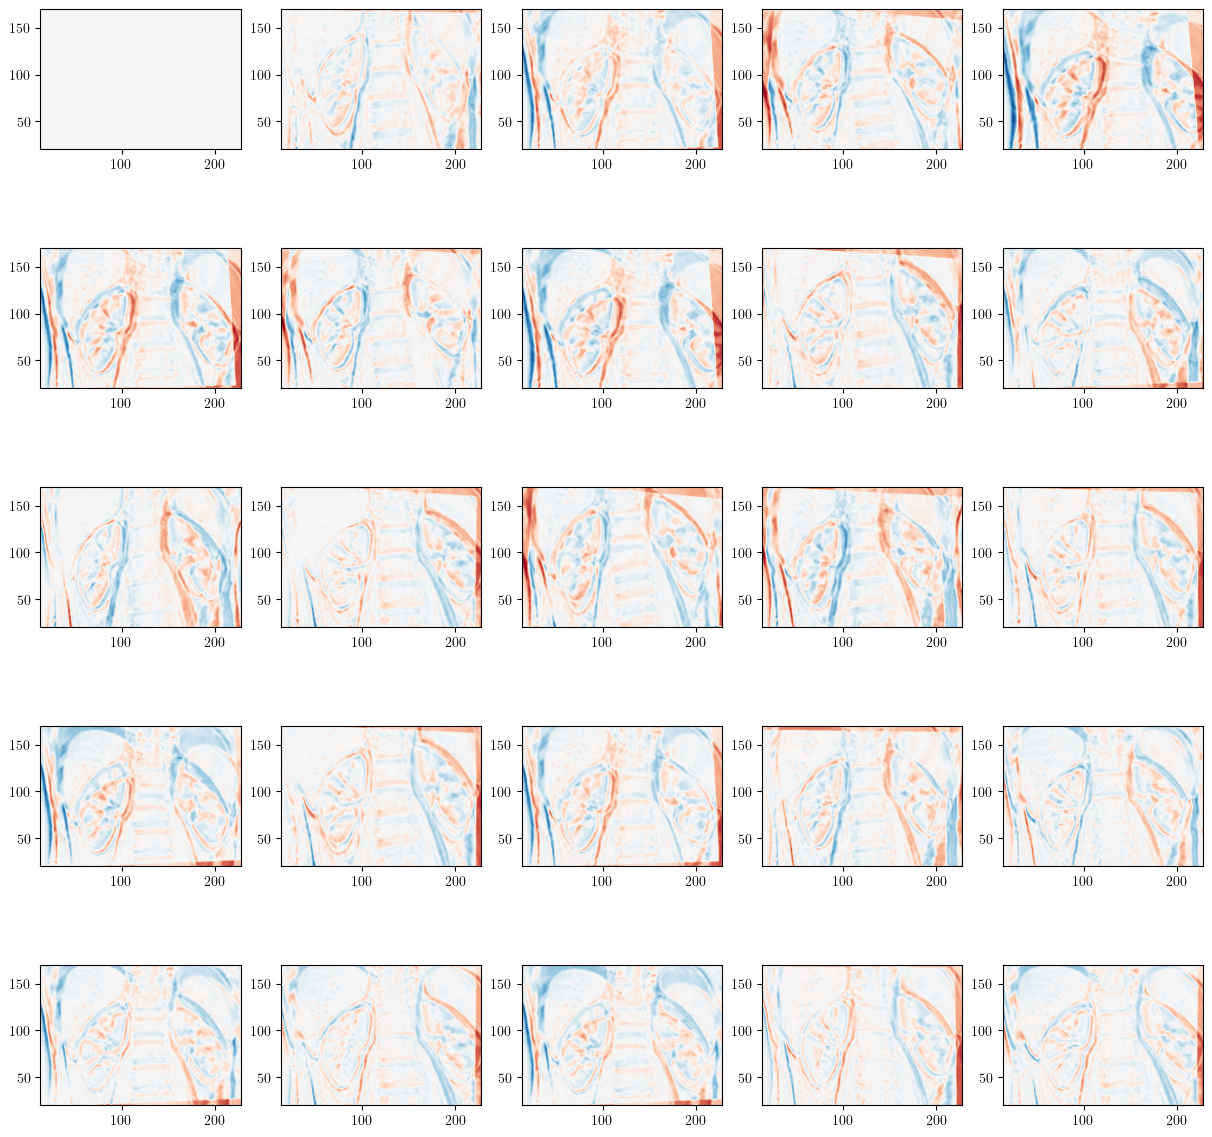

In [104]:
fig, ax = plt.subplots(5,5,figsize=(15,15))

for j in range(0,n_images):
    view_image_2d(f_pred[j].reshape(mx,my).detach() - d_2d[j], domain, ax=ax[j//5,j%5], kwargs={'clim':(-200,200), 'cmap':'RdBu'})

FileNotFoundError: [Errno 2] No such file or directory: 'results/dynamics/alpha_estimation.pdf'

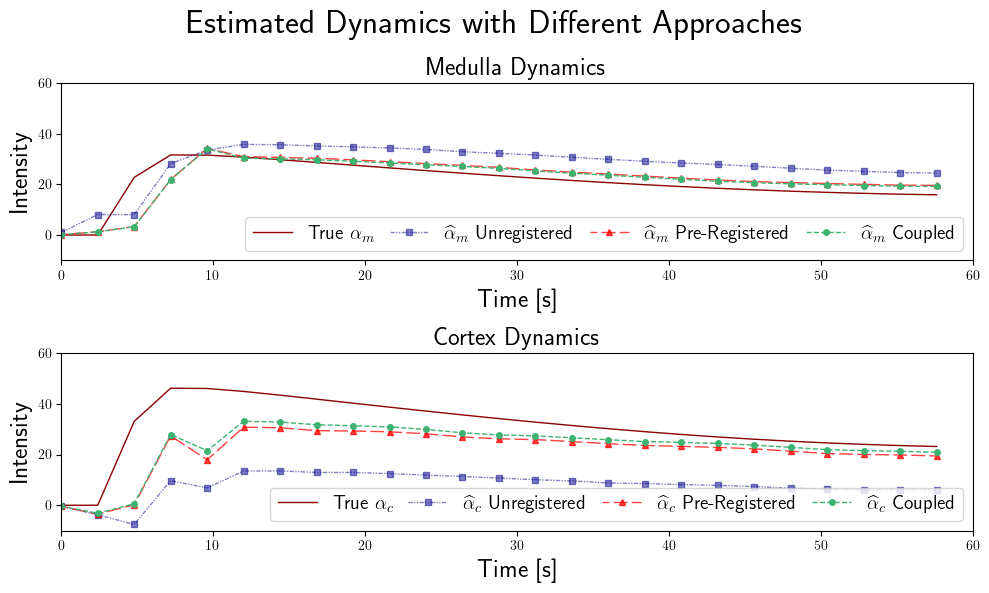

In [105]:
A = torch.vstack([torch.kron(torch.eye(n_images), M) * (hx * hy)**.5, L_alpha * torch.kron(Tau @ D, torch.eye(n_masks)) / ht**.5])

alpha_preregistered = torch.linalg.lstsq(A, 
                   torch.hstack([(f_pred_prereg - d[0]).flatten() * (hx * hy)**.5, torch.zeros(D.shape[0]*n_masks)])
                   )[0].reshape(n_images,n_masks)

alpha_coupled = torch.linalg.lstsq(A, 
                   torch.hstack([(f_pred_coupled - d[0]).flatten() * (hx * hy)**.5, torch.zeros(D.shape[0]*n_masks)])
                   )[0].reshape(n_images,n_masks)


fig, ax = plt.subplots(2, 1, figsize=(10,6), layout='tight')

ax[0].plot(time, alpha_true[:,0], linewidth=1, color='darkred', label=r"True $\alpha_m$", alpha=1)
ax[1].plot(time, alpha_true[:,1], linewidth=1, color='darkred', label=r"True $\alpha_c$", alpha=1)

ax[0].plot(time, alpha_unregistered[:,0], 's', markersize=4, linewidth=1, linestyle=(0, (3, 1, 1, 1, 1, 1)), color='darkblue', label=r"$\widehat{\alpha}_m$ Unregistered", alpha=.5)
ax[1].plot(time, alpha_unregistered[:,1], 's', markersize=4, linewidth=1, linestyle=(0, (3, 1, 1, 1, 1, 1)), color='darkblue', label=r"$\widehat{\alpha}_c$ Unregistered", alpha=.5)

ax[0].plot(time, alpha_preregistered[:,0], '^', markersize=4, linewidth=1, linestyle=(5,(10,3)), color='red', label=r"$\widehat{\alpha}_m$ Pre-Registered", alpha=.75)
ax[1].plot(time, alpha_preregistered[:,1], '^', markersize=4, linewidth=1, linestyle=(5,(10,3)), color='red', label=r"$\widehat{\alpha}_c$ Pre-Registered", alpha=.75)

ax[0].plot(time, alpha_coupled[:,0], 'o', markersize=4, linewidth=1, linestyle='dashed', color='mediumseagreen', label=r"$\widehat{\alpha}_m$ Coupled")
ax[1].plot(time, alpha_coupled[:,1], 'o', markersize=4, linewidth=1, linestyle='dashed', color='mediumseagreen', label=r"$\widehat{\alpha}_c$ Coupled")


ax[0].legend(fontsize=14, loc = 'lower right', ncol=4, columnspacing=0.8)
ax[1].legend(fontsize=14, loc = 'lower right', ncol=4, columnspacing=0.8)


ax[0].set_xlabel('Time [s]', fontsize=18)
ax[0].set_ylabel('Intensity', fontsize=18)

ax[1].set_xlabel('Time [s]', fontsize=18)
ax[1].set_ylabel('Intensity', fontsize=18)

ax[0].set_ylim(-10,60)
ax[1].set_ylim(-10,60)

ax[0].set_xlim(0,60)
ax[1].set_xlim(0,60)

ax[0].set_title("Medulla Dynamics", fontsize=18)
ax[1].set_title("Cortex Dynamics", fontsize=18)

plt.suptitle("Estimated Dynamics with Different Approaches",fontsize=24, y=.98)

plt.savefig('results/dynamics/alpha_estimation.pdf', bbox_inches='tight')

plt.show()

In [107]:
alpha_true_norms = torch.linalg.norm(alpha_true,dim=0)

alpha_unregistered_relative_error = torch.linalg.norm(alpha_unregistered - alpha_true,dim=0)/alpha_true_norms
alpha_preregistered_relative_error = torch.linalg.norm(alpha_preregistered - alpha_true,dim=0)/alpha_true_norms
alpha_coupled_relative_error = torch.linalg.norm(alpha_coupled - alpha_true,dim=0)/alpha_true_norms

print("Relative Errors \t Medulla \t\t Cortex")
print("Unregistered \t : \t {:.2%} \t\t {:.2%}".format(*alpha_unregistered_relative_error))
print("Preregistered \t : \t {:.2%} \t\t {:.2%}".format(*alpha_preregistered_relative_error))
print("Coupled \t : \t {:.2%} \t\t {:.2%}".format(*alpha_coupled_relative_error))

Relative Errors 	 Medulla 		 Cortex
Unregistered 	 : 	 36.89% 		 74.86%
Preregistered 	 : 	 22.91% 		 35.97%
Coupled 	 : 	 22.13% 		 32.13%


In [108]:
f_pred_prereg_2d = f_pred_prereg.reshape(n_images,mx,my)
f_pred_coupled_2d = f_pred_coupled.reshape(n_images,mx,my)

FileNotFoundError: [Errno 2] No such file or directory: 'results/dynamics/registration_slice_horizontal.pdf'

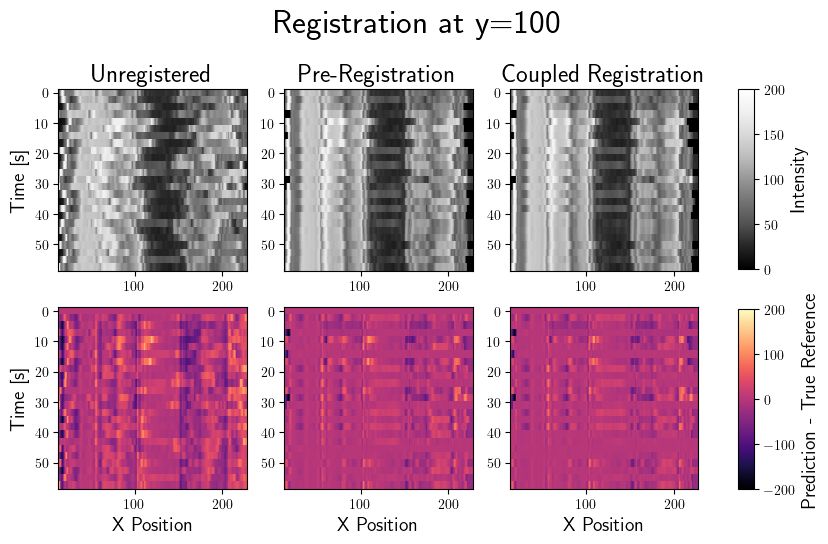

In [109]:
fig, ax = plt.subplots(2,3, figsize=(8,4))

ax[0,0].set_title("Unregistered", fontsize = 18)
ax[0,1].set_title("Pre-Registration", fontsize = 18)
ax[0,2].set_title("Coupled Registration", fontsize = 18)

im00 = ax[0,0].pcolor(xc_2d[:,0,0], time, d_2d[:,:,100 - 20], clim=(0,200), cmap = 'Greys_r')
im01 =ax[0,1].pcolor(xc_2d[:,0,0], time, f_pred_prereg_2d[:,:,100 - 20], clim=(0,200), cmap = 'Greys_r')
im02 = ax[0,2].pcolor(xc_2d[:,0,0], time, f_pred_coupled_2d[:,:,100 - 20], clim=(0,200), cmap = 'Greys_r')

im10 =ax[1,0].pcolor(xc_2d[:,0,0], time, d_2d[:,:,100 - 20] - f_2d[:,:,100 - 20], clim=(-200,200), cmap = 'magma')
im11 = ax[1,1].pcolor(xc_2d[:,0,0], time, f_pred_prereg_2d[:,:,100 - 20] - f_2d[:,:,100 - 20], clim=(-200,200), cmap = 'magma')
im12 = ax[1,2].pcolor(xc_2d[:,0,0], time, f_pred_coupled_2d[:,:,100 - 20] - f_2d[:,:,100 - 20], clim=(-200,200), cmap = 'magma')

im00.set_edgecolor('face')
im01.set_edgecolor('face')
im02.set_edgecolor('face')
im10.set_edgecolor('face')
im11.set_edgecolor('face')
im12.set_edgecolor('face')

ax[0,0].set_ylabel('Time [s]', fontsize = 14)
ax[1,0].set_ylabel('Time [s]', fontsize = 14)
ax[1,0].set_xlabel('X Position', fontsize = 14)
ax[1,1].set_xlabel('X Position', fontsize = 14)
ax[1,2].set_xlabel('X Position', fontsize = 14)

ax[0,0].invert_yaxis()
ax[0,1].invert_yaxis()
ax[0,2].invert_yaxis()
ax[1,0].invert_yaxis()
ax[1,1].invert_yaxis()
ax[1,2].invert_yaxis()

fig.subplots_adjust(0,0,.8,1)

# Create colorbar axes
cbar_ax1 = fig.add_axes([0.85, 0.55, 0.02, 0.45])  # x, y, width, height
cbar_ax2 = fig.add_axes([0.85, 0.0, 0.02, 0.45])

# Create colorbars in the new axes
cbar1 = plt.colorbar(im02, cax=cbar_ax1)
cbar2 = plt.colorbar(im12, cax=cbar_ax2)


cbar1.set_label(label = "Intensity", fontsize = 14)
cbar2.set_label(label = "Prediction - True Reference", fontsize = 14)


fig.suptitle("Registration at y=100", y=1.2, x = .45, fontsize=24)

plt.savefig('results/dynamics/registration_slice_horizontal.pdf', bbox_inches='tight')

plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'results/dynamics/registration_slice_vertical.pdf'

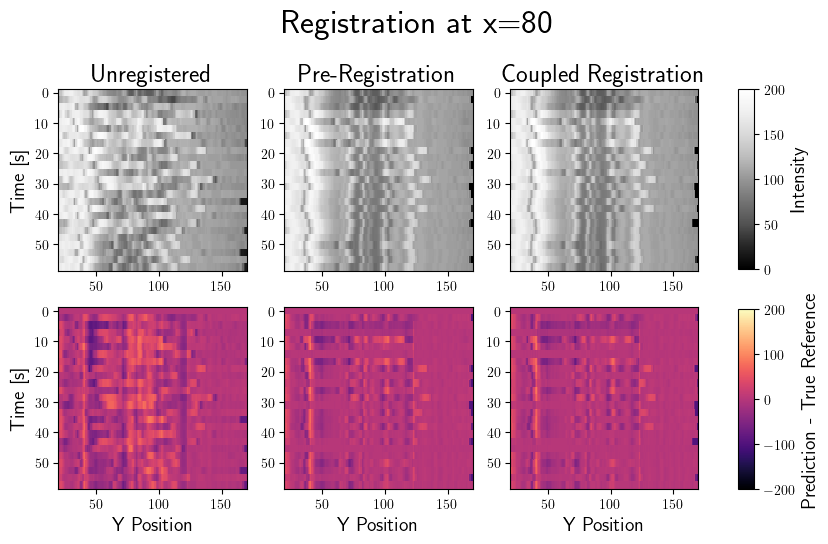

In [110]:
fig, ax = plt.subplots(2,3, figsize=(8,4))

ax[0,0].set_title("Unregistered", fontsize = 18)
ax[0,1].set_title("Pre-Registration", fontsize = 18)
ax[0,2].set_title("Coupled Registration", fontsize = 18)

im00 = ax[0,0].pcolor(xc_2d[0,:,1], time, d_2d[:,80-13,:], clim=(0,200), cmap = 'Greys_r')
im01 =ax[0,1].pcolor(xc_2d[0,:,1], time, f_pred_prereg_2d[:,80-13,:], clim=(0,200), cmap = 'Greys_r')
im02 = ax[0,2].pcolor(xc_2d[0,:,1], time, f_pred_coupled_2d[:,80-13,:], clim=(0,200), cmap = 'Greys_r')

im10 =ax[1,0].pcolor(xc_2d[0,:,1], time, d_2d[:,80-13,:] - f_2d[:,80-13,:], clim=(-200,200), cmap = 'magma')
im11 = ax[1,1].pcolor(xc_2d[0,:,1], time, f_pred_prereg_2d[:,80-13,:] - f_2d[:,80-13,:], clim=(-200,200), cmap = 'magma')
im12 = ax[1,2].pcolor(xc_2d[0,:,1], time, f_pred_coupled_2d[:,80-13,:]- f_2d[:,80-13,:], clim=(-200,200), cmap = 'magma')

im00.set_edgecolor('face')
im01.set_edgecolor('face')
im02.set_edgecolor('face')
im10.set_edgecolor('face')
im11.set_edgecolor('face')
im12.set_edgecolor('face')

ax[0,0].set_ylabel('Time [s]', fontsize = 14)
ax[1,0].set_ylabel('Time [s]', fontsize = 14)
ax[1,0].set_xlabel('Y Position', fontsize = 14)
ax[1,1].set_xlabel('Y Position', fontsize = 14)
ax[1,2].set_xlabel('Y Position', fontsize = 14)

ax[0,0].invert_yaxis()
ax[0,1].invert_yaxis()
ax[0,2].invert_yaxis()
ax[1,0].invert_yaxis()
ax[1,1].invert_yaxis()
ax[1,2].invert_yaxis()

fig.subplots_adjust(0,0,.8,1)

# Create colorbar axes
cbar_ax1 = fig.add_axes([0.85, 0.55, 0.02, 0.45])  # x, y, width, height
cbar_ax2 = fig.add_axes([0.85, 0.0, 0.02, 0.45])

# Create colorbars in the new axes
cbar1 = plt.colorbar(im02, cax=cbar_ax1)
cbar2 = plt.colorbar(im12, cax=cbar_ax2)


cbar1.set_label(label = "Intensity", fontsize = 14)
cbar2.set_label(label = "Prediction - True Reference", fontsize = 14)

fig.suptitle("Registration at x=80", y=1.2, x = .45, fontsize=24)

plt.savefig('results/dynamics/registration_slice_vertical.pdf', bbox_inches='tight')

plt.show()



In [ ]:
view_image_2d(d[0],domain)
plt.vlines(80,20,170, color='darkslategrey', label="x = 80", linewidth=5)
plt.hlines(100,13,228, color='lightcoral', label="y = 100", linewidth=5, alpha=.75)
plt.legend(fontsize=18)
plt.title("Slices on the Initial Image", fontsize=24)
plt.xlabel("X", fontsize=14)
plt.ylabel("Y", fontsize=14)

plt.savefig("results/dynamics/slices.pdf", bbox_inches='tight')

plt.show()